In [1]:
import numpy as nu
import matplotlib.pyplot as plt
from galpy.potential import SCFPotential, HernquistPotential,NFWPotential, compute_coeffs_spherical,compute_coeffs_axi, compute_coeffs
from galpy.potential import LogarithmicHaloPotential,FlattenedPowerPotential
from IPython.display import display, Math, Latex
from galpy.util.bovy_coords import cyl_to_spher, spher_to_cyl
%matplotlib inline  


#SCFPotential

## Examples

### Spherical density 

Consider $\rho (r) = \frac{1}{2\pi} \frac{1}{r (1 + r)^3}$

We get $A_{nlm} = \delta_{n0}\delta_{l0}\delta_{m0}$

In [2]:
def rho_Spherical(R, z=0, phi=0., a=1.):
    h = HernquistPotential(amp=1, a=a)
    return h.dens(R,z)
    r, theta, phi = cyl_to_spher(R,z, phi)
    return (2*nu.pi)**-1 * nu.power((r/a)*(a + r)**3 ,-1)

In [3]:
Acos, Asin = compute_coeffs_spherical(rho_Spherical,2, 1.)

Creating the SCFPotential object

In [4]:
scf = SCFPotential(1., Acos, Asin, 1.)

In [5]:
def calculateSCFDensity(scf, R, Z=0., phi=0.):
    return scf.dens(R, Z, phi)

In [6]:
R = nu.linspace(0.001, .1, 1000)
density = calculateSCFDensity(scf, R)
densityAnalytic = rho_Spherical(R, a=1.)

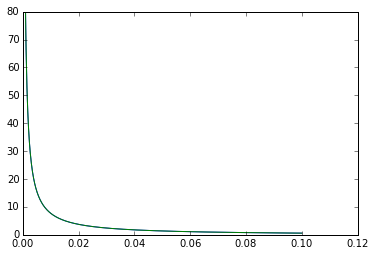

In [7]:
plt.plot(R, density)
plt.plot(R, densityAnalytic)

We confirm that our numerical density matches with our analytic density

### Hernquist potential

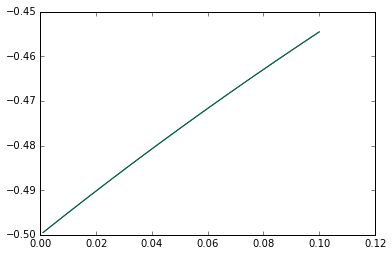

In [8]:
potential = scf(R, 0.)
h = HernquistPotential(1., 1.) ## Equation (2.1) and the implemented Hernquist amplitude has a factor 2 difference
z = nu.zeros(len(R))
hPotential = h(R,z)
plt.plot(R, potential)
plt.plot(R, hPotential)

Confirmed that the implemented SCF potential matches with the already implemented Hernquist potential.

The only note is amp=2. 

### Zeeuw's perfect ellipsoid

Consider $\rho (r) = \frac{3}{4\pi} \frac{1}{(1 + r)^4}$

We get $A_{nlm} = \frac{3}{4}\delta_{n0}\delta_{l0}\delta_{m0} + \frac{1}{12}\delta_{n1}\delta_{l0}\delta_{m0}$

In [9]:
def rho_Zeeuw(R, z=0., phi=0., a=1.):
    r, theta, phi = cyl_to_spher(R,z, phi)
    return 3./(4*nu.pi) * nu.power((a + r),-4.) * a

In [10]:
Acos, Asin = compute_coeffs_spherical(rho_Zeeuw, 2) 
scf = SCFPotential(1., Acos, Asin, 1)

In [11]:
density = calculateSCFDensity(scf, R)
densityAnalytic = rho_Zeeuw(R)


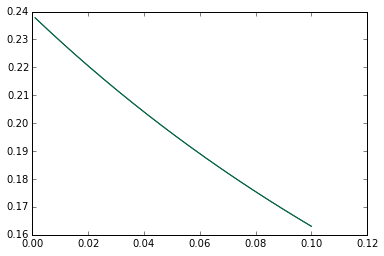

In [12]:
plt.plot(R, density)
plt.plot(R, densityAnalytic)

### NFW Density

Consider $\rho (r) = \frac{1}{4\pi} \frac{1}{r (1 + r)^2}$

In [13]:
a_NFW= 1.
a_SCF= [1., 4, 10., 30.]

def rho_NFW(R, z=0, phi=0.):
    return nfw.dens(R,z)

In [14]:
R = nu.linspace(.1,1.,1000)
nfw = NFWPotential(amp=1.,a=a_NFW)
nfwDensity = nfw.dens(R,0)

In [15]:
Acos, Asin = compute_coeffs_spherical(rho_NFW,80)
scf = SCFPotential(amp=1., Acos=Acos, Asin=Asin)
density = scf.dens(R,0)

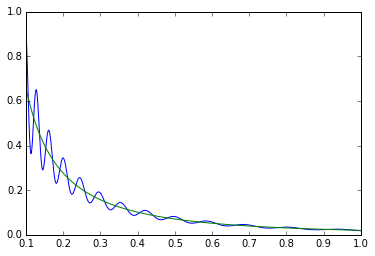

In [16]:
plt.plot(R, density)
plt.plot(R, nfwDensity)

In [17]:
def plotDensityVaryinga(dens, N, aparem):
    density = nu.zeros((len(aparem), len(R)), float)
    plt.title("NFW Density with N={}".format(N))
    for i in range(len(aparem)):
        a = aparem[i]
        Acos, Asin = compute_coeffs_spherical(dens,N,a=a)
        scf = SCFPotential(1., Acos, Asin,a=a)
        density[i] = calculateSCFDensity(scf,R)
        
        plt.plot(R, density[i], label="a={0}".format(a))
    plt.plot(R, dens(R), label="NFW Density")
    plt.legend()
    #plt.ylim(-20,100)
    return density


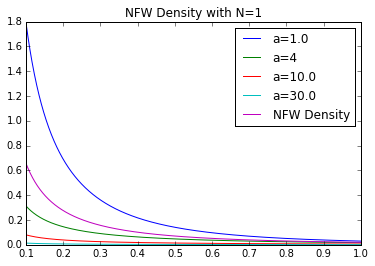

In [18]:
density = plotDensityVaryinga(rho_NFW, 1, a_SCF)

As we can see, the function does not match well enough for N=1.

Let's try increasing the size of the coefficients 

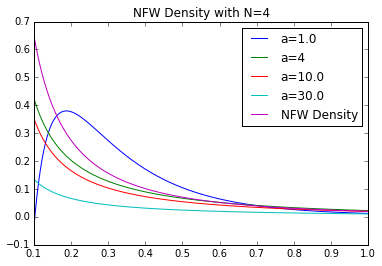

In [19]:
density = plotDensityVaryinga(rho_NFW, 4, a_SCF)

a = 1 is now the worst match. Other than that, the other paremater choices got better. If I were to judge, it looks like a=4 is the best choice for N=4. Let's ommit a=1 from now on.

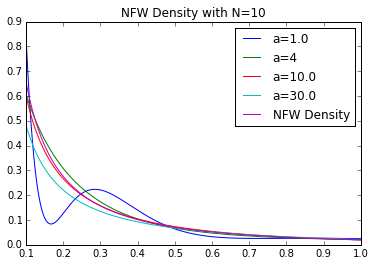

In [20]:
density = plotDensityVaryinga(rho_NFW, 10, a_SCF[:])

a=4 is now the worse choice. It looks like a=10 is the best choice for N=10

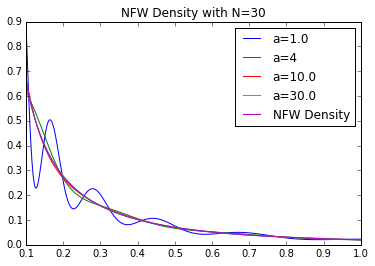

In [21]:
density = plotDensityVaryinga(rho_NFW, 30, a_SCF[:])

a=4 is now doing terrible. It looks like a=30. is the best choice for N=30.

###NFW Potential

In [22]:
R = nu.linspace(.1,10, 1000)
nfw = NFWPotential(amp=1.,a=1)
nfwPotential = nfw(R,0)

In [23]:
Acos, Asin = compute_coeffs_spherical(rho_NFW,10,a=1.)
scf = SCFPotential(amp=1, a=1.,Acos=Acos, Asin=Asin)
potential = scf(R,0)

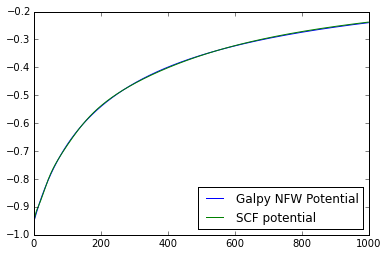

In [24]:
plt.plot(nfwPotential, label="Galpy NFW Potential")
plt.plot(potential, label="SCF potential")
plt.legend(loc="lower right")

### Axisymmetric density

We'll check if compute_coeffs_axi reduces to compute_coeffs_spherical for a spherical function, as we expect it to.

First, some useful functions that is unique to spherical densities

In [25]:
epi = 1e-10

##Testing the coeffecients
def test_Acosn(As, Aa):
    return nu.all(nu.fabs(As[0][:,:1,:1] - Aa[0][:,:1,:1]) < epi)
def test_Acos_nbiggerthan0(Aa):
    return nu.all(nu.fabs(Aa[0][:,1:,:]) <epi)
def test_Asin_allZero(As, Aa):
    return nu.all(nu.fabs(As[1]) < epi) and nu.all(nu.fabs(Aa[1]) < epi)

def test_all(As,Aa):
    return test_Acosn(As,Aa) and test_Acos_nbiggerthan0(Aa) and test_Asin_allZero(As,Aa)



rho_Spherical

In [26]:
Aspherical = compute_coeffs_spherical(rho_Spherical,10)
Aaxi = compute_coeffs_axi(rho_Spherical, 10, 10)
print test_all(Aspherical,Aaxi)

True


Zeeuw

In [27]:
Aspherical = compute_coeffs_spherical(rho_Zeeuw,10)
Aaxi = compute_coeffs_axi(rho_Zeeuw, 10, 10)
print test_all(Aspherical,Aaxi)

True


###Testing with an axi symmetric density

In [28]:
def axi_density1(R, z=0, phi=0.):
    spherical_coords = cyl_to_spher(R,z, phi)
    r, theta, phi = spherical_coords
    h = HernquistPotential(2)
    return h.dens(R, z, phi)*(1 + eps*nu.cos(theta) + eps*nu.cos(theta)**2.)

def axi_density2(R, z=0, phi=0.):
    spherical_coords = cyl_to_spher(R,z, phi)
    theta = spherical_coords[1]
    return rho_Zeeuw(R,z,phi)*(1 + eps*nu.cos(theta) + eps*nu.cos(theta)**2)

In [29]:
eps = 0
Aaxi = compute_coeffs_axi(axi_density1, 5,5)
Aspherical = compute_coeffs_spherical(axi_density1, 5)
print "axi_density1 reduces to HernquistPotential at eps=0:", test_all(Aspherical, Aaxi)

Aaxi = compute_coeffs_axi(axi_density2, 5,5)
Aspherical = compute_coeffs_spherical(axi_density2, 5)
print "axi_density2 reduces to Zeeuw's potential at eps=0:", test_all(Aspherical, Aaxi)

axi_density1 reduces to HernquistPotential at eps=0: True
axi_density2 reduces to Zeeuw's potential at eps=0: True


In [30]:
eps = 1.
A = compute_coeffs_axi(axi_density1, 10,10)
## Expecting non-zero elements at (n,l) = (0,0), (0,2)
print bool(nu.fabs(A[0][0,0,0]>1e-14) and nu.fabs(A[0][0,2,0]>1e-14))
scf = SCFPotential(1., A[0], A[1])

True


For the following, refer to [how I analytically calculated A](http://localhost:8888/notebooks/SCFPotential_mathematics.ipynb#Example)

In [31]:
analytically_calculated = nu.array([4./3, 7.* 3**(-5/2.), 2*11*5**(-5./2), 0])
numerically_calculated = nu.around(A[0][0,:4,0], 15)

print "Setting n = 0"
for l in range(len(analytically_calculated)):
    print "At (n,l) = ({0},{1}): \t analytically calculated A = {2} \t numerically calculated A = {3}".format(0, l, analytically_calculated[l], numerically_calculated[l])
    
analytically_calculated = nu.array([4./3, 0, 0, 0])
numerically_calculated = nu.around(A[0][:4,0,0], 15)

print "\nSetting l = 0"
for n in range(len(analytically_calculated)):
    print "At (n,l) = ({0},{1}): \t analytically calculated A = {2} \t numerically calculated A = {3}".format(n, 0, analytically_calculated[n], numerically_calculated[n])
    
analytically_calculated = nu.array([0,0,0, 0])
numerically_calculated = nu.around(A[0][1,:4,0],15)

print "\nSetting n = 2"
for l in range(len(analytically_calculated)):
    print "At (n,l) = ({0},{1}): \t analytically calculated A = {2} \t numerically calculated A = {3}".format(1, l, analytically_calculated[l], numerically_calculated[l])
    
    
analytically_calculated = nu.array([0,11. / (3.**(5./2) * 5 * 7. * 2), 1. / (2*3.*5**.5*7.), 0])
numerically_calculated = nu.around(A[0][2,:4,0],15)

print "\nSetting n = 2"
for l in range(len(analytically_calculated)):
    print "At (n,l) = ({0},{1}): \t analytically calculated A = {2} \t numerically calculated A = {3}".format(2, l, analytically_calculated[l], numerically_calculated[l])

Setting n = 0
At (n,l) = (0,0): 	 analytically calculated A = 1.33333333333 	 numerically calculated A = 1.33333333333
At (n,l) = (0,1): 	 analytically calculated A = 0.44905020937 	 numerically calculated A = 0.44905020937
At (n,l) = (0,2): 	 analytically calculated A = 0.39354796404 	 numerically calculated A = 0.39354796404
At (n,l) = (0,3): 	 analytically calculated A = 0.0 	 numerically calculated A = -1.7e-14

Setting l = 0
At (n,l) = (0,0): 	 analytically calculated A = 1.33333333333 	 numerically calculated A = 1.33333333333
At (n,l) = (1,0): 	 analytically calculated A = 0.0 	 numerically calculated A = 0.0
At (n,l) = (2,0): 	 analytically calculated A = 0.0 	 numerically calculated A = 0.0
At (n,l) = (3,0): 	 analytically calculated A = 0.0 	 numerically calculated A = 0.0

Setting n = 2
At (n,l) = (1,0): 	 analytically calculated A = 0 	 numerically calculated A = 0.0
At (n,l) = (1,1): 	 analytically calculated A = 0 	 numerically calculated A = -0.0
At (n,l) = (1,2): 	 anal

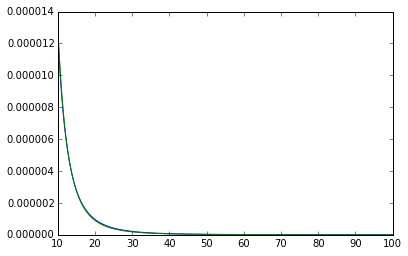

In [32]:
R = nu.linspace(10.,100,1000)
plt.plot(R, calculateSCFDensity(scf, R,1., 0))
plt.plot(R, axi_density1(R, 1., 0))

Unfortunatly, compute_coeffs_axi took a longer time for Flattened Power Potential

In [33]:
eps = 1.
A = compute_coeffs_axi(axi_density2, 5,5)
## Expecting non-zero elements at (n,l) = (0,0), (0,2), (1,0), (1,2)
print bool(nu.fabs(A[0][0,0,0]>1e-14) and nu.fabs(A[0][0,2,0]>1e-14) and nu.fabs(A[0][1,0,0]>1e-14) and nu.fabs(A[0][1,2,0]>1e-14))
scf = SCFPotential(1., A[0], A[1])

True


In [34]:
analytically_calculated = nu.array([1., 7.* 3**(-3/2.) /4., 3*11*5**(-5./2)/2., 0])
numerically_calculated = nu.around(A[0][0,:4,0], 13)

print "Setting n = 0"
for l in range(len(analytically_calculated)):
    print "At (n,l) = ({0},{1}): \t analytically calculated A = {2} \t numerically calculated A = {3}".format(0, l, analytically_calculated[l], numerically_calculated[l])
    
analytically_calculated = nu.array([0, 11./(7*5*3**(3./2)*2**(3.)), (7 * 5**(.5)*2**3.)**-1., 0])
numerically_calculated = nu.around(A[0][2,:4,0], 13)

print "Setting n = 2"
for l in range(len(analytically_calculated)):
    print "At (n,l) = ({0},{1}): \t analytically calculated A = {2} \t numerically calculated A = {3}".format(2, l, analytically_calculated[l], numerically_calculated[l])

Setting n = 0
At (n,l) = (0,0): 	 analytically calculated A = 1.0 	 numerically calculated A = 1.0
At (n,l) = (0,1): 	 analytically calculated A = 0.336787657027 	 numerically calculated A = 0.336787657027
At (n,l) = (0,2): 	 analytically calculated A = 0.29516097303 	 numerically calculated A = 0.29516097303
At (n,l) = (0,3): 	 analytically calculated A = 0.0 	 numerically calculated A = -0.0
Setting n = 2
At (n,l) = (2,0): 	 analytically calculated A = 0.0 	 numerically calculated A = -0.0
At (n,l) = (2,1): 	 analytically calculated A = 0.00756053923939 	 numerically calculated A = 0.0075605392394
At (n,l) = (2,2): 	 analytically calculated A = 0.0079859570625 	 numerically calculated A = 0.0079859570625
At (n,l) = (2,3): 	 analytically calculated A = 0.0 	 numerically calculated A = -0.0


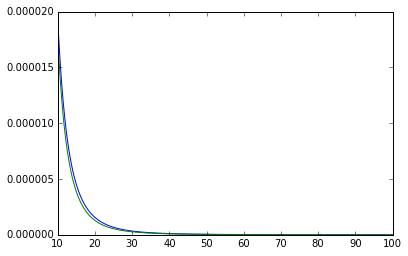

In [35]:
R = nu.linspace(10.,100,1000)
plt.plot(R, calculateSCFDensity(scf, R,1., 0))
plt.plot(R, axi_density2(R, 1., 0))

### Flattened Power Potential

In [36]:
def FlattenedPowerDensity(R,z,phi=0):
    lh = FlattenedPowerPotential()
    return lh.dens(R,z,phi)

I have decided to leave this at N=30 and L=30. Play around with the values to see how the following plot changes.
The bigger the coeffecient size, the slower it'll take. The smaller the coeffecient size, the less accurate the potentials (not like they're accurate to begin with). 

In [37]:
A = compute_coeffs_axi(FlattenedPowerDensity, 30,30)

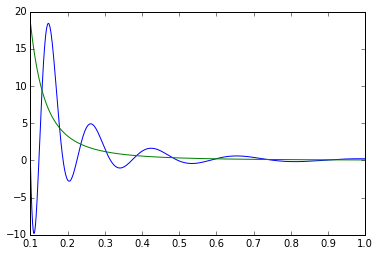

In [38]:
scf = SCFPotential(1., A[0], A[1])
R = nu.linspace(.1,1,1000)
plt.plot(R, calculateSCFDensity(scf, R, 0., 0))
plt.plot(R, FlattenedPowerDensity(R, 0., 0))

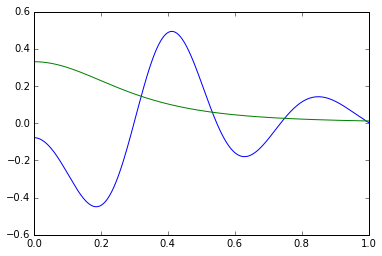

In [39]:
z = nu.linspace(0, 1,1000)
plt.plot(z, calculateSCFDensity(scf, nu.ones((1000))*.5, z, 0))
plt.plot(z, FlattenedPowerDensity(nu.ones((1000))*.5, z, 0))

##Issues with large l

In [40]:
eps = 10 ##Spherical density
Acos, Asin = compute_coeffs_axi(axi_density1, 40,40)

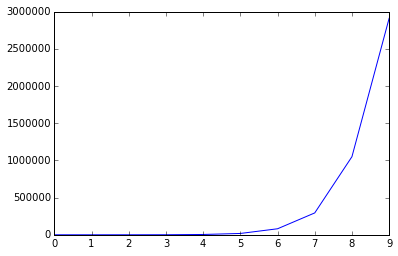

In [41]:
plt.plot(Acos[0,30:,0])

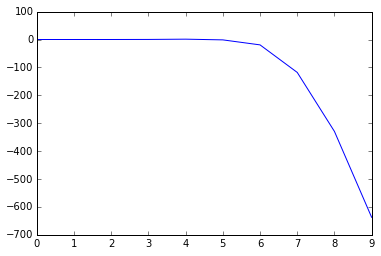

In [42]:
plt.plot(Acos[1,30:,0])

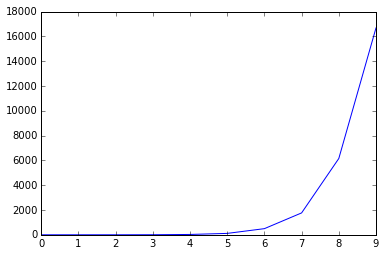

In [43]:
plt.plot(Acos[2,30:,0])

At first, I thought this was a huge problem which was would be my proof that I did something wrong. Let's try plotting the potentials and comparing them.

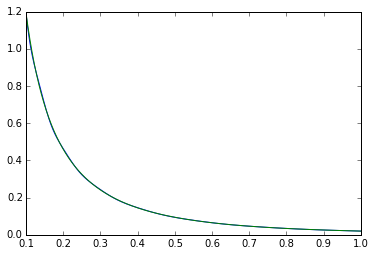

In [44]:
scf = SCFPotential(1., Acos, Asin, 1)
R = nu.linspace(.1,1,1000)
plt.plot(R, calculateSCFDensity(scf, R, 0., 0))
plt.plot(R, axi_density1(R, 0., 0))

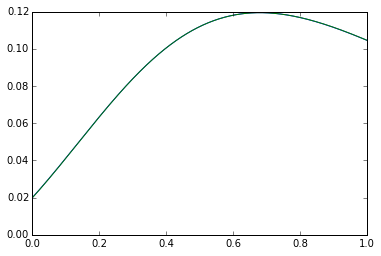

In [45]:
R = nu.ones((1000))
Z = nu.linspace(0,1,1000)
plt.plot(z, calculateSCFDensity(scf, R, z, 0))
plt.plot(z, axi_density1(R, z, 0))

Even though the expansion coeffecients turns really ugly for small n but large l, the figures still match for varying R and Z.

## 3D Expansion Coeffecients

In [46]:
def density1(R, z=0, phi=0.):
    spherical_coords = cyl_to_spher(R,z, phi)
    r, theta, phi = spherical_coords
    h = HernquistPotential(2)
    return h.dens(R, z, phi)*(1 + eps*nu.cos(theta) + eps*nu.cos(theta)**2.)*(1 + eps*nu.cos(phi) + eps*nu.sin(phi))

def density2(R, z=0, phi=0.):
    spherical_coords = cyl_to_spher(R,z, phi)
    theta = spherical_coords[1]
    return rho_Zeeuw(R,z,phi)*(1 + eps*nu.cos(theta) + eps*nu.cos(theta)**2)*(1 + eps*nu.cos(phi) + eps*nu.sin(phi))

In [47]:
A1cos, A1sin = compute_coeffs(density1, 10, 10)

Here, I see an issue. At l=8, A1cos should be zero for all m. However, what I'm seeing here is that as m increases, the coeffecient increases, eventually to a significant amount. What confuses me here the most is that, looking at my code and the math, we should actually be seeing the coeffecient decrease in magnitude. 

In [48]:
print A1cos[0,8,:]

[  5.60468737e-11  -1.71844401e+03  -1.81089405e-11   2.30944638e-11
   1.72499288e-09   1.55731586e-06   3.09831254e-04   3.09899474e-02
   5.05063664e-01  -0.00000000e+00]


In [49]:
R = nu.linspace(1,10,100)
scf = SCFPotential(Acos=A1cos, Asin=-A1sin)
density = scf.dens(R, 0)

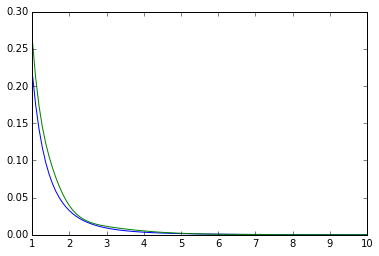

In [50]:
plt.plot(R, density1(R))
plt.plot(R, density)

In [51]:
z = nu.linspace(0,10,100)
density = scf.dens(1, z)

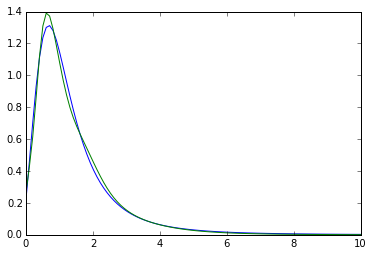

In [52]:
plt.plot(z, density1(1, z))
plt.plot(z, density)

In [53]:
phi = nu.linspace(0, 2*nu.pi, 100)
density = scf.dens(1, 0, phi)

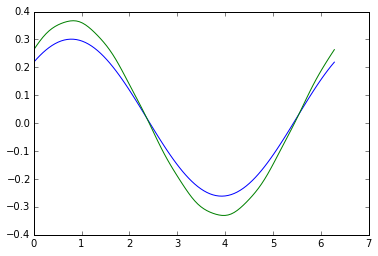

In [54]:
plt.plot(phi, density1(1, 0, phi))
plt.plot(phi, density)

Here, A1 will refer to the coeffecients as computed by compute_coeffs_axi

A2 will refer to the coeffecients as computed by compute_coeffs

Due to the long execution time, we will only compute A2 for size (5,5,5), and compare these values with A1[:5,:5,:5]

We will then plot scf1 (using A1), scf2 (using A2), and the actual density on the same plot. Note that scf1 will always be more accurate because it uses a bigger coeffecient size. But if we use the same size as A1 (5,5,5), you'd see that the density for A1 matches with A2. 

In [55]:
eps = 1.
epsilon = 1e-13
A1cos, A1sin = compute_coeffs_axi(axi_density1, 30,30)
A2cos, A2sin = compute_coeffs(axi_density1, 5,5)
print nu.all(nu.fabs(A1cos[:5,:5,:5] - A2cos) < epsilon) and nu.all(nu.fabs(A1sin[:5,:5,:5] - A2sin) <epsilon )

True


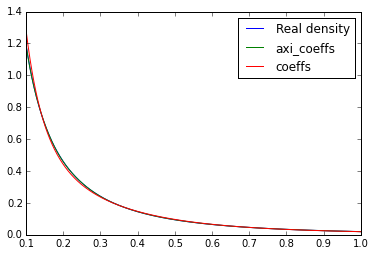

In [56]:
R = nu.linspace(.1,1,1000)
scf1 = SCFPotential(1., A1cos, A1sin)
scf2 = SCFPotential(1., A2cos, A2sin)
plt.plot(R, axi_density1(R,0.), label="Real density")
plt.plot(R, calculateSCFDensity(scf1, R, 0., 0), label="axi_coeffs")
plt.plot(R, calculateSCFDensity(scf2, R, 0., 0.), label="coeffs")
plt.legend()

In [57]:
eps = 1.
A1cos, A1sin = compute_coeffs_axi(axi_density2, 15,15)
A2cos, A2sin = compute_coeffs(axi_density2, 5,5)
print nu.all(nu.fabs(A1cos[:5,:5,:5] - A2cos) < epsilon) and nu.all(nu.fabs(A1sin[:5,:5,:5] - A2sin) <epsilon )

True


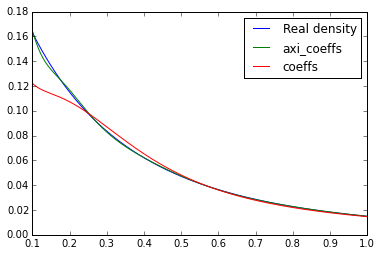

In [58]:
R = nu.linspace(.1,1,1000)
scf1 = SCFPotential(1., A1cos, A1sin)
scf2 = SCFPotential(1., A2cos, A2sin)
plt.plot(R, axi_density2(R,0.), label="Real density")
plt.plot(R, calculateSCFDensity(scf1, R, 0., 0), label="axi_coeffs")
plt.plot(R, calculateSCFDensity(scf2, R, 0., 0.), label="coeffs")
plt.legend()